In [1]:
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, linear_model, metrics

import numpy as np

In [10]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [33]:
#обучение простой модельки на просто датасете
blobs = datasets.make_blobs(centers = 2, cluster_std = 5.5, random_state=1)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(blobs[0], blobs[1], test_size = 0.3, random_state = 1)
log_regressor = linear_model.LogisticRegression(random_state = 1, solver='lbfgs')
log_regressor.fit(train_data, train_labels)
predictions = log_regressor.predict(test_data)
proba_predictions = log_regressor.predict_proba(test_data)

## Метрики классификации

In [24]:
#Матрица квадратная, в позиции (i, j) стоит количество объектов, которые имели метку i,  а мы поставили им метку j (для классификации)
metrics.confusion_matrix(test_labels, predictions)
#остальные 4 метрики считаются по этой матрице

array([[14,  4],
       [ 0, 12]], dtype=int64)

In [13]:
#accuracy ((0,0) + (1,1)) / ((0,0) + (0,1) + (1,0) + (1,1))
metrics.accuracy_score(test_labels, predictions)

0.8666666666666667

In [22]:
#precision (1,1) / ((0,1) + (1,1))
metrics.precision_score(test_labels, predictions)

0.75

In [20]:
#recall (0,0) / ((0,0) + (1,0))
metrics.recall_score(test_labels, predictions)

array([[14,  4],
       [ 0, 12]], dtype=int64)

In [27]:
# f1
metrics.f1_score(test_labels, predictions)

0.8571428571428571

In [32]:
#общая инфа по метрикам
print(metrics.classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.75      1.00      0.86        12

   micro avg       0.87      0.87      0.87        30
   macro avg       0.88      0.89      0.87        30
weighted avg       0.90      0.87      0.87        30



In [38]:
# функция потерь логлосс чем меньше, тем лучше
metrics.log_loss(test_labels, proba_predictions[:,1])

0.3422091698067107

0.9583333333333334


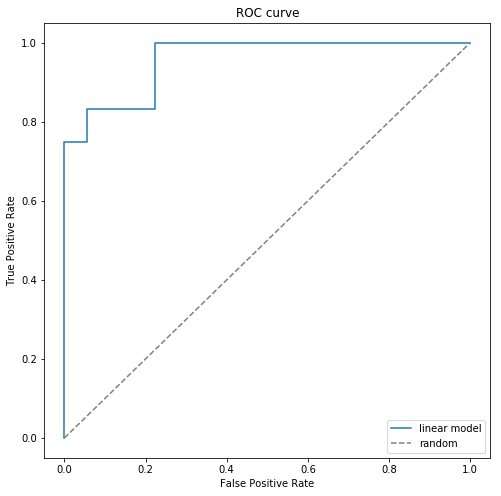

In [35]:
fpr, tpr, _ = metrics.roc_curve(test_labels, proba_predictions[:,1])
pylab.plot(fpr, tpr, label = 'linear model')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve')
pylab.legend(loc = "lower right")

print(metrics.roc_auc_score(test_labels, proba_predictions[:,1]))

## Метрики регрессии

In [39]:
#mean_absolute_error помним, что она отрицательная, так как в задачах мы максимиируем метрики
metrics.mean_absolute_error(test_labels, predictions)
# если зодовать через скоррер, то
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [41]:
#mean_absolute_error помним, что она отрицательная, так как в задачах мы максимиируем метрики
metrics.mean_squared_error(test_labels, predictions)

0.2

In [43]:
#коэффициент детерминации (сколько дисперсии удалось объяснить моделью)
metrics.r2_score(test_labels, predictions)

0.16666666666666685

## Кросс-валидация

Если стоит задача бинарной классификации, то в кросс-валидации по-умолчанию осуществляется StratifiedKFold

In [11]:
from sklearn.model_selection import cross_val_score

In [15]:
# cv -- количество разбиений
ridge_scoring = model_selection.cross_val_score(ridge_classifier, blobs[0], blobs[1], scoring = 'accuracy', cv = 10)
print(ridge_scoring.mean())

0.8800000000000001


cross_val_score с заданными scorer (метрика качества) и cv_strategy(стратегия кросс-валидации)

In [19]:
# задание метрики
scorer = metrics.make_scorer(metrics.accuracy_score)
# задание стратегии
cv_strategy = model_selection.StratifiedShuffleSplit(n_splits = 20 , test_size = 0.3, random_state = 2)

ridge_scoring = model_selection.cross_val_score(ridge_classifier, blobs[0], blobs[1], scoring = scorer, cv = cv_strategy)
print(ridge_scoring.mean())

0.8700000000000001


## Создание сценария Pipeline

In [14]:
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, linear_model, metrics

In [16]:
#Подготовим данные
import numpy as np
import pandas as pd

raw_data = pd.read_csv('./data/bike_sharing_demand.csv', header = 0, sep = ',')
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)
#Для первого сценария
# raw_data = raw_data[['temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'count']]
#Для второго сценария
raw_data = raw_data.drop(['datetime', 'casual', 'registered'], axis = 1)

train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]
train_labels = train_data['count'].values
train_data = train_data.drop(['count'], axis = 1)
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['count'], axis = 1)

In [15]:
#создадим, например, сценарий, в котором будем данные сперва масштабировать, а потом применять регрессию
#здесь главное, чтобы у классов, используемых в пайплайне, был метод fit и get_params
scaler = StandardScaler()
regressor = linear_model.SGDRegressor(random_state = 0)
# создание сценария
pipeline = sklearn.pipeline.Pipeline(steps = [('scaling', scaler), ('regression', regressor)])
# посмотрим, что можем задавать у скеллера и регрессора
print(pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])


In [18]:
# Есть возможность граммотной предобработки признаков с помощью пайплайна
# Более подробное описание методов обработки в preprocessing.ipynb
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

estimator = sklearn.pipeline.Pipeline(steps = [       
    ('feature_processing', sklearn.pipeline.FeatureUnion(transformer_list = [        
            #binary (ничего не делаем)
            ('binary_variables_processing', sklearn.preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric (масштабируем)
            ('numeric_variables_processing', sklearn.pipeline.Pipeline(steps = [
                ('selecting', sklearn.preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', sklearn.preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical (разбиваем на бинарные признаки)
            ('categorical_variables_processing', sklearn.pipeline.Pipeline(steps = [
                ('selecting', sklearn.preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)
estimator.fit(test_data, test_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x0000016FF44F8F28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=...ndom_state=0, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False))])

## Прогон модели по сетке параметров GridSearch

In [20]:
# создадим сетку параметров для пайплайна, созданного ранее
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__n_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}
# зададим функцию, для прогона пайплайна
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 10)
# и прогоняем
grid_cv.fit(train_data, train_labels)
print(grid_cv.best_score_) # лучшая метрика
print(grid_cv.best_params_) # соответствующие ей параметры
grid_cv.best_estimator_ # возвращает лучший метод (класс)

UsageError: Line magic function `%%time` not found.


In [25]:
#для более шустрой работы можно использовать случайную сетку
randomized_grid_cv = model_selection.RandomizedSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 10, n_iter = 20, random_state = 0)